In [39]:
import os
import sklearn
import numpy as np
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import mne
from mne.preprocessing import ICA
import pywt
from scipy.stats import skew, kurtosis
from scipy.signal import spectrogram
from mne.viz import plot_topomap
from scipy.signal import welch
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import optuna
from sklearn.datasets import make_classification
from PIL import Image, ImageDraw, ImageFont
from joblib import dump
from scipy.signal import butter, filtfilt, lfilter, lfilter_zi
from sklearn.linear_model import SGDClassifier

#####################################################################################
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
fs=250

####################################################################################
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    return df_new

def df_to_raw(df, sfreq=250):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor = 3
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes]) # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.01  # Make interpolated values 0.01 times smaller
    # Again Check each interpolated value's difference from median and compare to the threshold
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.01 
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.01 
    df[channel] = interpolated_values
    return df

#########################################################################################
current_directory = os.getcwd()
patient_data_folder = os.path.join(current_directory, "2-Patient Data")

print(f"Current directory: {current_directory}")
print(f"Patient data folder: {patient_data_folder}")

folder_name = input("Please enter the subject name: ")
Report_Number = input("Please enter the reprt number: ")
full_folder_path = os.path.join(patient_data_folder, folder_name)

# root_folder = "2-Patient Data"
sub_folders = ["Pre Evaluation", "Neurofeedback", "Post Evaluation"]
phase = int(input("Enter the phase (0, 1, 2): "))  # Or however you get the phase value
# Determine which sub-folders to use based on the phase
folders_to_use = []
if phase == 0:
    folders_to_use = [sub_folders[0]]  # Just "Pre Evaluation"
elif phase == 1:
    folders_to_use = sub_folders[:2]  # "Pre Evaluation" and "Neurofeedback"
elif phase == 2:
    folders_to_use = [sub_folders[2]]  # 
print('folders_to_use:', folders_to_use)
# Iterate over each folder to read the csv files

################################################################################################
duration = 40 
raw=[]
event=[]
BP=[]
PP=[]
B=[]
Human_Behavior=[]
eeg_processed=[]
for folder in folders_to_use:
    full_folder_path_ = os.path.join(full_folder_path, folder)
    print('full_folder_path_', full_folder_path_)
    if os.path.exists(full_folder_path_) and os.path.isdir(full_folder_path_):
        print(f"Reading from: {full_folder_path_}")
        for file_name in os.listdir(full_folder_path_):
            if file_name.endswith('.csv') and (file_name.startswith('raw_eeg_block') or file_name.startswith('fl_')):
                file_path = os.path.join(full_folder_path_, file_name)
                s_temp = pd.read_csv(file_path, header=None)
                inst = s_temp.iloc[:, 17]
                df_temp = s_temp.iloc[:, :8]
                raw.append(df_temp)
                event.append(inst)
                HB=s_temp.iloc[1750:, 17:21]
                inst = s_temp.iloc[:, 17]
                Human_Behavior.append(HB)
                
                # 1. Band Pass
                raw_bp = np.copy(df_temp)
                for column in range(8):
                    raw_bp[:, column] = butter_bandpass_filter(raw_bp[:, column], lowcut=.4, highcut=40, fs=250) 
                # print('raw_bp.shape', raw_bp.shape)
                
                # 2. Artifact rejection
                BP_artifact_RJ = np.copy(raw_bp)
                for channel in range (8):
                    BP_artifact_RJ= reject_artifacts(pd.DataFrame(BP_artifact_RJ), channel)
                
                # 4. Denoising and other preprocessing
                BP_artifact_RJ.columns = selected_columns
                eeg_df_denoised = preprocess(pd.DataFrame(BP_artifact_RJ), col_names=selected_columns, n_clusters=[10]*len(selected_columns))
                
                #concate the labels to the processed data
                eeg_df_denoised_inst=pd.concat([eeg_df_denoised,inst], axis=1) 
                
                
                # I preprocessed the whole data in each block, then, split it to the base and the activity signal
                baseline=eeg_df_denoised.iloc[:1750,]
                dd=eeg_df_denoised.iloc[1750:,]
                
                # print('eeg_df_denoised.shape',dd.shape)
                # eeg_df_denoised.plot(subplots=True, figsize=(15, 10), title='Denoised EEG Data')
                # plt.show()
                eeg_processed.append(eeg_df_denoised_inst)
                B.append(baseline)
                PP.append(dd)
    else:
        print(f"{full_folder_path_} does not exist")

Current directory: c:\Users\Maryam\Documents\GitHub\Neurofeedback-Based-BCI_r
Patient data folder: c:\Users\Maryam\Documents\GitHub\Neurofeedback-Based-BCI_r\2-Patient Data
folders_to_use: ['Pre Evaluation']
full_folder_path_ c:\Users\Maryam\Documents\GitHub\Neurofeedback-Based-BCI_r\2-Patient Data\mz0\Pre Evaluation
Reading from: c:\Users\Maryam\Documents\GitHub\Neurofeedback-Based-BCI_r\2-Patient Data\mz0\Pre Evaluation


In [42]:
baserejected=[]
face=[]
scene=[]
EEG=[]
event_=[]
for i in range (len(eeg_processed)):
    pp_data=eeg_processed[i]
    instruction = pp_data.iloc[:, 8]
    baseline = pp_data[pp_data.iloc[:, -1].isin(['b', 'g'])].iloc[:, :-1]
    baseline_avg = baseline.mean()
    non_baseline_data = pp_data[~pp_data.iloc[:, -1].isin(['b', 'g'])]
    inst_activity=non_baseline_data.iloc[:, 8]
    adjusted_non_baseline = non_baseline_data.iloc[:, :-1] - baseline_avg
    concatenated = pd.concat([baseline, adjusted_non_baseline], ignore_index=True)
    pp_data_baseline_rejected= pd.concat([concatenated, instruction], axis=1)
    activity_baseline_rejected_with_inst= pd.concat([adjusted_non_baseline, inst_activity], axis=1)
    baserejected.append(activity_baseline_rejected_with_inst)
    # Check if the last column contains 'I' or 'O'
    if 'I' in instruction.values or 'O' in instruction.values:
        scene.append(pp_data_baseline_rejected)            
    if 'M' in instruction.values or 'F' in instruction.values:
        face.append(pp_data_baseline_rejected)                        
    # df_temp = pp_data.iloc[:, :8]
    # EEG.append(df_temp)
    # event_.append(instruction)
     
    

In [46]:
baserejected_np = np.vstack(baserejected)
label_brj = baserejected_np[:, -1:]

labels=[]
for i in range(len(baserejected_np)): #len(pp_sig_event) = the whole sample points, (df_temp.shape[0]*B_N)
    if 'M' in baserejected_np[i, 8] or 'F' in baserejected_np[i, 8]:
        labels.append(0)
    if 'I' in baserejected_np[i, 8] or 'O' in baserejected_np[i, 8]:
        labels.append(1)

labels=np.array(labels)

# Array with all columns except the last
rest_of_baserejected_np=baserejected_np[:, :-1]

baserejected_np_reshaped=rest_of_baserejected_np.reshape(int(baserejected_np.shape[0]/250), 250*8)
label_brj_reshaped=labels.reshape(int(baserejected_np.shape[0]/250), 250)

In [50]:
face_np=np.array(face)
scene_np=np.array(scene)

In [8]:
# #######################################################################################################################################################
# # Define the new list to store baseline corrected data
# baseline_corrected = []
# for baseline, dd in zip(B, PP):
#     baseline_avg = baseline.mean()
#     corrected = dd -baseline_avg
#     baseline_corrected.append(corrected)
    
# baseline_corrected_np=np.array(baseline_corrected)
# print('baseline_corrected_np.shape',baseline_corrected_np.shape)

# event_np=np.array(event)
# print('event_np.shape',event_np.shape)
# label_np=event_np[:,1750:]
# print('label_np.shape',label_np.shape)

# B_N=int(len(baseline_corrected)) #Number of blocks
# PP_NP=baseline_corrected_np #shape: (B_N, 10000, 8=Channel Numbers)

# EVENTS=label_np.reshape(B_N*(baseline_corrected_np.shape[1]), 1)
# print('EVENTS', EVENTS)
# denoised=PP_NP.reshape(B_N*(baseline_corrected_np.shape[1]), 8) # seprate each blocks' signal 
# pp_sig_event=np.concatenate((denoised,EVENTS), axis=1) 

# event_column_index = pp_sig_event.shape[1] - 1

# # Create a boolean mask where the event is not 'n'
# mask = pp_sig_event[:, event_column_index] != 'N'

# # Apply the mask to filter out rows with event 'n', because our focus is on the correct attention
# pp_sig_event_filtered = pp_sig_event[mask]
# pp_sig_event_no_event_column = pp_sig_event_filtered[:, :-1]


# labels=[] 
# face = [] #lable=0
# scene=[]#lable=1
# base=[] # label=2
# # Aassuming correctness for the human behavior
# for i in range(len(pp_sig_event_filtered)): #len(pp_sig_event) = the whole sample points, (df_temp.shape[0]*B_N)
#     if 'M' in pp_sig_event_filtered[i, 8] or 'F' in pp_sig_event_filtered[i, 8]:
#         face.append(pp_sig_event_filtered[i])
#         labels.append(0)
#     if 'I' in pp_sig_event_filtered[i, 8] or 'O' in pp_sig_event_filtered[i, 8] or 'S' in pp_sig_event_filtered[i, 8]:
#         scene.append(pp_sig_event_filtered[i]) 
#         labels.append(1)        
# face = np.array(face)
# print('face.shape', face.shape)
# scene = np.array(scene)
# print('scene.shape', scene.shape)
# labels=np.array(labels) 
# print('label.shape', labels.shape, labels)

baseline_corrected_np.shape (8, 10000, 8)
event_np.shape (8, 11750)
label_np.shape (8, 10000)
EVENTS [['F']
 ['F']
 ['F']
 ...
 ['I']
 ['I']
 ['I']]
face.shape (40000, 9)
scene.shape (40000, 9)
label.shape (80000,) [0 0 0 ... 1 1 1]


In [ ]:
# ###############################################################################################################
# # Score
# if phase !=  1:
#     Human_Behavior_np=np.array(Human_Behavior).reshape(B_N*(baseline_corrected_np.shape[1]), 4)
#     denoised_im_ins_HB = np.concatenate((denoised, Human_Behavior_np), axis=1)
#     SCORE = []
#     for row in denoised_im_ins_HB:
#         condition1 = (row[-4] == row[-3]) or (row[-4] == row[-2])
#         condition2 = row[-1] == 1
#         condition3 = (row[-4] != row[-3]) and (row[-4] != row[-2])
#         condition4 = row[-1] == 0
#         if (condition1 and condition2) or (condition3 and condition4):
#             SCORE.append([1])
#         else:
#             SCORE.append([0])
#     print('score length', len(SCORE))
#     #score
#     win_size = 250
#     S = []
#     for i in range(0, len(SCORE), win_size):
#         S_data = SCORE[i:i+win_size]
#         S.append(S_data)
#     # print('s lenght', len(S))
#     # print(S)
#     S_np = np.array(S)
#     print('S_np shape', S_np.shape)
#     result_list = []
#     # Iterate through the "images" (first dimension)
#     for i in range(S_np.shape[0]):
#         # Check if all 250 samples are 0
#         if np.all(S_np[i, :, 0] == 0):
#             result_list.append(0)
#         else:
#             result_list.append(1)
#     # print(result_list)
#     mean_value = sum(result_list) / len(result_list)
#     print("Mean of result list:", mean_value)
#     percentage_of_ones = mean_value * 100
#     rounded_percentage_of_ones = round(percentage_of_ones)
#     n=str(rounded_percentage_of_ones)
#     print('n', n)
#     img=Image.new('RGB', (1000,1000), color=(73,109,137))
#     d=ImageDraw.Draw(img)
#     font_0=ImageFont.truetype("arial.ttf", 500)
#     font_1=ImageFont.truetype("arial.ttf", 150)
#     d.text((150,50), "Your Score", font=font_1, fill=(255,255,0))
#     d.text((250,250), n, font=font_0, fill=(255,255,0))
#     img_file_name = f"Score.png"
#     img_file_path = os.path.join(full_folder_path_, img_file_name) 
#     print('img_file_path', img_file_path)
#     img.save(img_file_path, index=False)
# else:
#     print(f"No score in phase_{phase}")

In [51]:
import numpy as np
import pandas as pd

def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)
    wavelet = sine_wave * amplitude_envelope
    return wavelet

def convolve_with_wavelet(data, wavelet):
    # Ensure data is in 2D form
    if data.ndim == 1:
        data = data[np.newaxis, :]
    n_signal = data.shape[1]
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    data_fft = np.fft.fft(data, n_convolution, axis=1)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)[np.newaxis, :]
    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = np.fft.ifft(convolution_result_fft, axis=1)
    # Cut the data
    start = (n_wavelet - 1) // 2
    end = start + n_signal
    return convolution_result[:, start:end]

In [ ]:
# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']

In [ ]:
data_f = face_np  
# Initialize a dictionary to store power matrices for each channel
power_matrices_f = {channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    power_matrix_f = []
    for freq, cycle in zip(frequencies, cycles):
        power_blocks_base_corrected=[]
        for i in range (len(data_f)): #12
            data_f_i_np= data_f[i]
            data_f_i_np_t=np.transpose(data_f_i_np)

            # Extract one channel
            data_f_i_t = data_f_i_np_t[channel_idx, :]  # Trials are on the second dimension
            data_f_i_inst = data_f_i_np_t[8, :]
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(data_f_i_t , wavelet)    
            power = np.abs(convolution)**2

            data_f_i_inst_2d = data_f_i_inst[np.newaxis, :]
            power_with_inst=np.concatenate([power,data_f_i_inst_2d], axis=0)
            power_with_inst_t=np.transpose(power_with_inst)
            mask = (power_with_inst_t[:, 1] == 'b') | (power_with_inst_t[:, 1] == 'g')
            base_l= power_with_inst_t[mask]
            base= base_l[:, :-1]
            print(base.shape)
            mean_base= np.mean(base_l[:, :-1], axis=0)
            print('mean_base', mean_base)
            
            epoch_size = 250
            epochs_base = []
            for start in range(0, len(base), epoch_size):
                end = start + epoch_size
                if end <= len(base):
                    epochs_base.append(base[start:end])
                else:
                    epochs_base.append(base[start])
                epochs_base_np=np.array(epochs_base)
            print('epochs_base_np.shape', epochs_base_np.shape)
            
            # Calculate the mean across the first dimension, excluding the last column
            mean_epochs_base = np.mean(epochs_base_np, axis=0)

            first_200 = mean_epochs_base[:200]
            mean_base_200=np.mean(first_200, axis=0)
            
            # print('mean_base',mean_base_200)
            last_50 = mean_epochs_base[200:]
            # print('last_50', last_50)
            
            # # print('base', base.shape, base)
            activity = power_with_inst_t[~mask]
            # print('activity ', activity.shape, activity )
            
            epoch_size = 250
            epochs = []
            for start in range(0, len(activity), epoch_size):
                end = start + epoch_size
                if end <= len(activity):
                    epochs.append(activity[start:end, :-1])
                else:
                    epochs.append(activity[start:,:-1])
                epochs_np=np.array(epochs)
            print(epochs_np.shape)
            
            # Calculate the mean across the first dimension, excluding the last column
            activity_mean_epochs = np.mean(epochs_np, axis=0)
            # print('activity_mean_epochs', activity_mean_epochs.shape) #activity_mean_epochs (250, 1)
            activity_mean_epochs_concat_base=np.concatenate([last_50,activity_mean_epochs], axis=0)
            print('activity_mean_epochs_concat_base', activity_mean_epochs_concat_base.shape) #activity_mean_epochs_concat_base (300, 1)
            
            baseline_corrected_activity=activity_mean_epochs_concat_base/mean_base_200
            print('baseline_corrected_activity', baseline_corrected_activity.shape) #baseline_corrected_activity (300, 1)
            
            power_blocks_base_corrected.append(baseline_corrected_activity)
            # power_blocks_base_corrected_np= np.array(power_blocks_base_corrected)
            # print('power_blocks_base_corrected_np', power_blocks_base_corrected_np.shape)     
        power_blocks_base_corrected_np_mean_f=np.mean(power_blocks_base_corrected, axis=0)
        print('power_blocks_base_corrected_np_mean', power_blocks_base_corrected_np_mean_f.shape)
        power_matrices_f[channel_name].append(power_blocks_base_corrected_np_mean_f)
        power_matrix_f.append(power_blocks_base_corrected_np_mean_f)
        power_matrix_np_f=np.array(power_matrix_f)
        print('power_matrix_np', power_matrix_np_f.shape)

In [ ]:
data_s = scene_np  
# Initialize a dictionary to store power matrices for each channel
power_matrices_s = {channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    power_matrix_s = []
    for freq, cycle in zip(frequencies, cycles):
        power_blocks_base_corrected=[]
        for i in range (len(data_s)): #12
            data_s_i_np= data_s[i]
            data_s_i_np_t=np.transpose(data_s_i_np)

            # Extract one channel
            data_s_i_t = data_s_i_np_t[channel_idx, :]  # Trials are on the second dimension
            data_s_i_inst = data_s_i_np_t[8, :]
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(data_s_i_t , wavelet)    
            power = np.abs(convolution)**2

            data_s_i_inst_2d = data_s_i_inst[np.newaxis, :]
            power_with_inst=np.concatenate([power,data_s_i_inst_2d], axis=0)
            power_with_inst_t=np.transpose(power_with_inst)
            mask = (power_with_inst_t[:, 1] == 'b') | (power_with_inst_t[:, 1] == 'g')
            base_l= power_with_inst_t[mask]
            base= base_l[:, :-1]
            print(base.shape)
            mean_base= np.mean(base_l[:, :-1], axis=0)
            print('mean_base', mean_base)
            
            epoch_size = 250
            epochs_base = []
            for start in range(0, len(base), epoch_size):
                end = start + epoch_size
                if end <= len(base):
                    epochs_base.append(base[start:end])
                else:
                    epochs_base.append(base[start])
                epochs_base_np=np.array(epochs_base)
            print('epochs_base_np.shape', epochs_base_np.shape)
            
            # Calculate the mean across the first dimension, excluding the last column
            mean_epochs_base = np.mean(epochs_base_np, axis=0)

            first_200 = mean_epochs_base[:200]
            mean_base_200=np.mean(first_200, axis=0)
            
            # print('mean_base',mean_base_200)
            last_50 = mean_epochs_base[200:]
            # print('last_50', last_50)
            
            # # print('base', base.shape, base)
            activity = power_with_inst_t[~mask]
            # print('activity ', activity.shape, activity )
            
            epoch_size = 250
            epochs = []
            for start in range(0, len(activity), epoch_size):
                end = start + epoch_size
                if end <= len(activity):
                    epochs.append(activity[start:end, :-1])
                else:
                    epochs.append(activity[start:,:-1])
                epochs_np=np.array(epochs)
            print(epochs_np.shape)
            
            # Calculate the mean across the first dimension, excluding the last column
            activity_mean_epochs = np.mean(epochs_np, axis=0)
            # print('activity_mean_epochs', activity_mean_epochs.shape) #activity_mean_epochs (250, 1)
            activity_mean_epochs_concat_base=np.concatenate([last_50,activity_mean_epochs], axis=0)
            print('activity_mean_epochs_concat_base', activity_mean_epochs_concat_base.shape) #activity_mean_epochs_concat_base (300, 1)
            
            baseline_corrected_activity=activity_mean_epochs_concat_base/mean_base_200
            print('baseline_corrected_activity', baseline_corrected_activity.shape) #baseline_corrected_activity (300, 1)
            
            power_blocks_base_corrected.append(baseline_corrected_activity)
            # power_blocks_base_corrected_np= np.array(power_blocks_base_corrected)
            # print('power_blocks_base_corrected_np', power_blocks_base_corrected_np.shape)     
        power_blocks_base_corrected_np_mean_s=np.mean(power_blocks_base_corrected, axis=0)
        print('power_blocks_base_corrected_np_mean', power_blocks_base_corrected_np_mean_s.shape)
        power_matrices_s[channel_name].append(power_blocks_base_corrected_np_mean_s)
        power_matrix_s.append(power_blocks_base_corrected_np_mean_s)
        power_matrix_np_s=np.array(power_matrix_s)
        print('power_matrix_np', power_matrix_np_s.shape)

In [76]:
top_20_per_channel_s = {}
top_20_per_channel_f = {}

for channel in selected_columns:
    # Flattened data for both classes
    flattened_data_s = []
    flattened_data_f = []

    # Process for power_matrices_s
    for freq_idx, matrix in enumerate(power_matrices_s[channel]):
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                flattened_data_s.append((matrix[i, j], freq_idx, i, j))

    # Process for power_matrices_f
    for freq_idx, matrix in enumerate(power_matrices_f[channel]):
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                flattened_data_f.append((matrix[i, j], freq_idx, i, j))

    # Sort and select top 20 for power_matrices_s
    flattened_data_s.sort(key=lambda x: x[0], reverse=True)
    top_20_per_channel_s[channel] = flattened_data_s[:10]

    # Sort and select top 20 for power_matrices_f
    flattened_data_f.sort(key=lambda x: x[0], reverse=True)
    top_20_per_channel_f[channel] = flattened_data_f[:10]



In [78]:
top_20_per_channel_f['Po8']

[(1.4461229374773743, 5, 49, 0),
 (1.4439366420251227, 5, 48, 0),
 (1.4401838960790945, 5, 47, 0),
 (1.4349145452691434, 5, 46, 0),
 (1.4281894266223103, 5, 45, 0),
 (1.4200790755636605, 5, 44, 0),
 (1.4106622510088291, 5, 43, 0),
 (1.4000243438366113, 5, 42, 0),
 (1.388255739089779, 5, 41, 0),
 (1.37999914020057, 2, 213, 0)]

In [79]:
top_20_per_channel_s['Po8']

[(1.6333887791494914, 1, 205, 0),
 (1.633332437460402, 1, 206, 0),
 (1.6332644327167296, 1, 204, 0),
 (1.6330966448237403, 1, 207, 0),
 (1.6329582287784121, 1, 203, 0),
 (1.6326826944547053, 1, 208, 0),
 (1.6324690781500726, 1, 202, 0),
 (1.6320919246751298, 1, 209, 0),
 (1.631795984846772, 1, 201, 0),
 (1.6313257089742583, 1, 210, 0)]

In [55]:
import numpy as np
import pandas as pd

for channel, power_data in power_matrices_f.items():
    # Convert the list of arrays into a 2D array
    power_matrix = np.concatenate(power_data, axis=1)  # Concatenate along the second axis

    # Convert to DataFrame
    df = pd.DataFrame(power_matrix)

    # Save to CSV
    df.to_csv(f'face_power_matrix_{channel}.csv', index=False)

In [57]:
import numpy as np
import pandas as pd

for channel, power_data in power_matrices_s.items():
    # Convert the list of arrays into a 2D array
    power_matrix = np.concatenate(power_data, axis=1)  # Concatenate along the second axis

    # Convert to DataFrame
    df = pd.DataFrame(power_matrix)

    # Save to CSV
    df.to_csv(f'scene_power_matrix_{channel}.csv', index=False)

In [58]:
# Calculate the sampling interval
sampling_interval = 1 / 250  
times = np.arange(0, 1, step=sampling_interval)
times = times * 1000  

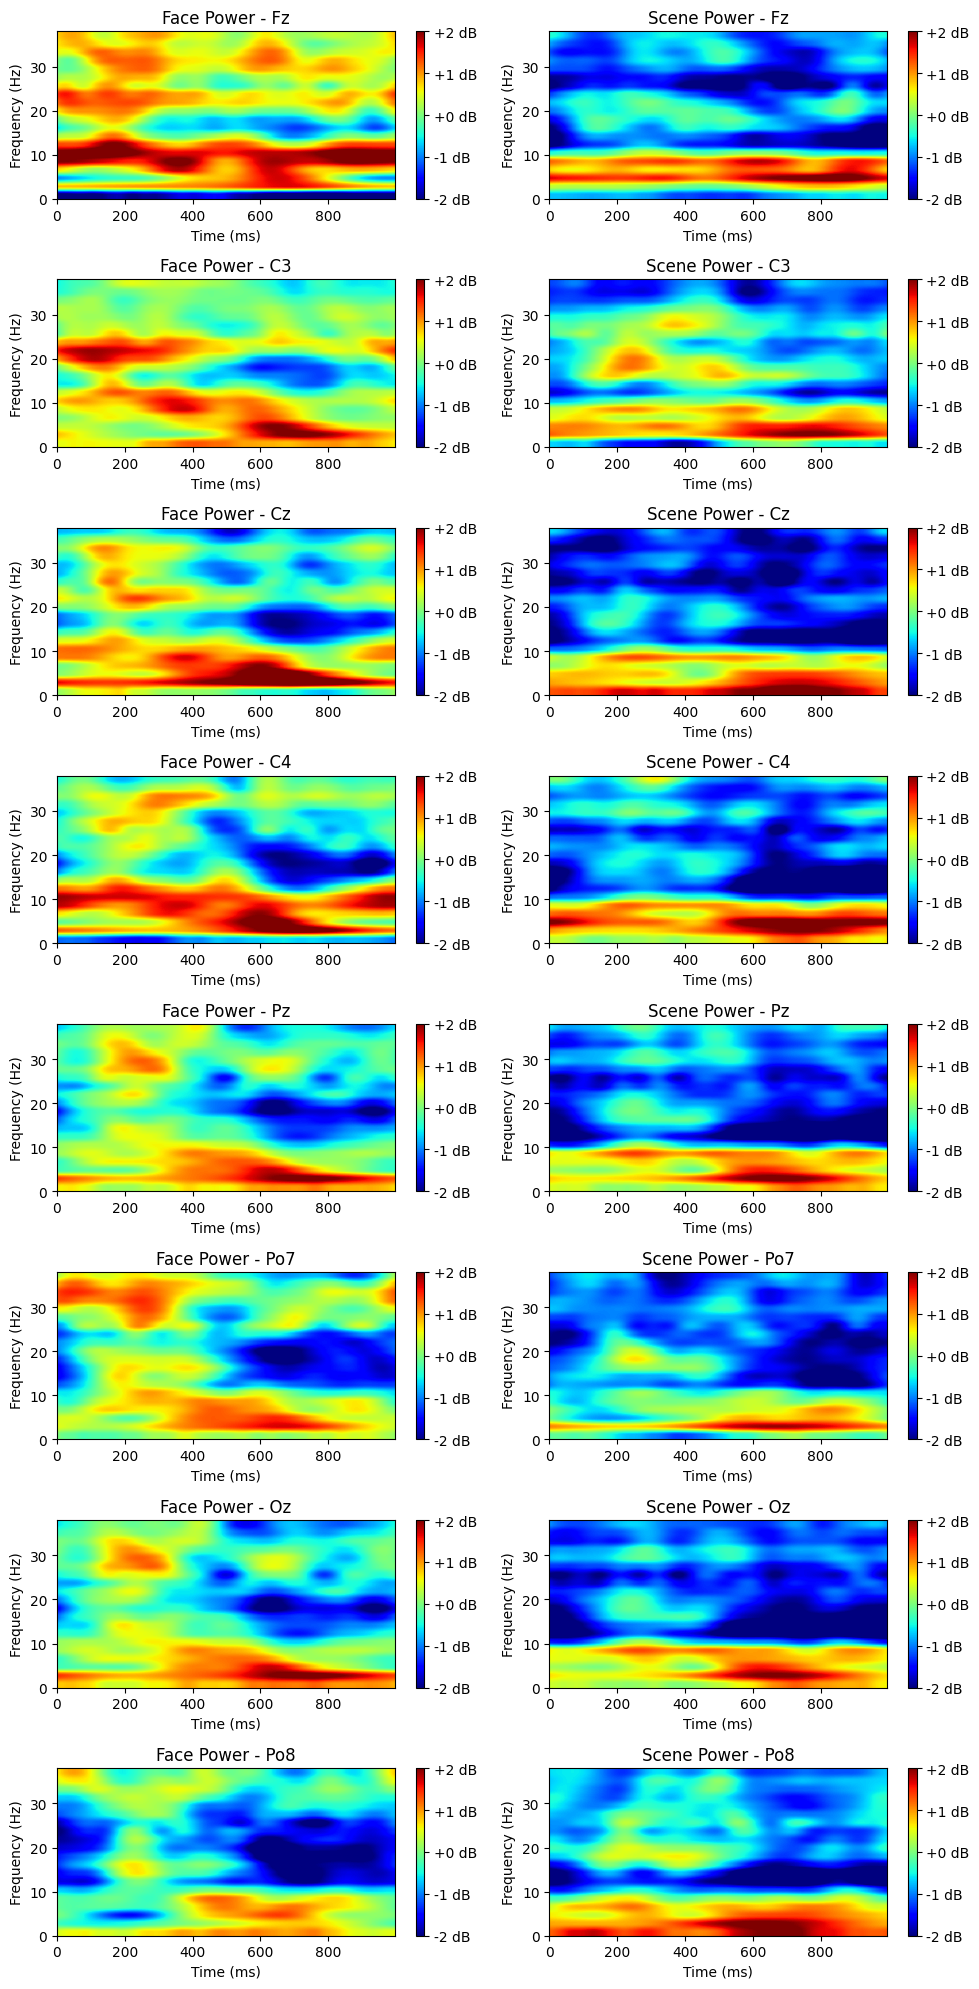

In [75]:
def plot_time_frequency(data, title, ax):
    # Use the provided axes object for plotting
    data_to_plot = 10 * np.log10(data.T + 1e-6)  # Transpose and Log transform of power; add a small constant to avoid log(0)
    img = ax.imshow(data_to_plot, aspect='auto', cmap='jet', origin='lower',
                    extent=[times[0], times[-1], frequencies[0], frequencies[-1]], vmin=-2, vmax=2)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')  # Use fig.colorbar to specify the axes
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)


n_channels = 8
fig, axs = plt.subplots(n_channels, 2, figsize=(10, 20))  # Adjust figsize as needed

for i, channel in enumerate(selected_columns):
    # Load from CSV
    df_face = pd.read_csv(f'face_power_matrix_{channel}.csv')
    df_scene = pd.read_csv(f'scene_power_matrix_{channel}.csv')

    # Convert DataFrame to numpy array
    face_power_matrix = df_face.to_numpy()
    scene_power_matrix = df_scene.to_numpy()

    # Use the data from the 50th sample point to 300th
    face_power_matrix_reduced = face_power_matrix[50:300, :]
    scene_power_matrix_reduced = scene_power_matrix[50:300, :]

    # Plot the results for face and scene
    plot_time_frequency(face_power_matrix_reduced, f'Face Power - {channel}', axs[i, 0])
    plot_time_frequency(scene_power_matrix_reduced, f'Scene Power - {channel}', axs[i, 1])

plt.tight_layout()
plt.show()



In [12]:
################################################################################################################
#Input to the classifier
label=labels.reshape(int(labels.shape[0]/fs), fs)
Y=np.squeeze(label[:,0])
print('Y.shape', Y.shape)
denoised_reshaped = pp_sig_event_no_event_column.reshape(int(pp_sig_event_no_event_column.shape[0]/250), 250, 8)
print('denoised_reshaped.shape',denoised_reshaped.shape)

mlp_data=denoised_reshaped.reshape(denoised_reshaped.shape[0], denoised_reshaped.shape[1]*denoised_reshaped.shape[2])
print('mlp_data.shape', mlp_data.shape)

af_mlp=mlp_data
Y_mlp=np.squeeze(label[:,0])
print(af_mlp.shape, Y_mlp.shape)
af_mlp, Y_mlp= shuffle(af_mlp, Y_mlp)
print(af_mlp.shape, Y_mlp.shape)

# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled_mlp, y_resampled_mlp = oversampler.fit_resample(af_mlp, Y_mlp)
X_resampled_mlp= X_resampled_mlp.astype(np.float32)
y_resampled_mlp = y_resampled_mlp.astype(np.int32)
print('X_resampled_mlp.shape', X_resampled_mlp.shape)
#Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled_mlp,y_resampled_mlp, test_size=0.1, random_state=42)
#Split to train and validation
X_train_mlp, X_validation_mlp, y_train_mlp, y_validation_mlp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

########################################################################################################################################



Y.shape (320,)
denoised_reshaped.shape (320, 250, 8)
mlp_data.shape (320, 2000)
(320, 2000) (320,)
(320, 2000) (320,)
X_resampled_mlp.shape (320, 2000)
Validation Accuracy: 0.6551724137931034


d:\11-software\Python3.8\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [4]:
np.unique(y_train_mlp)

array([0, 1])

In [38]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

# Create an RBF sampler
rbf_feature = RBFSampler(gamma=.05, random_state=1)

# Create an SGD classifier
sgd_clf = SGDClassifier(loss='log', max_iter=1000, tol=1e-3)

# Create a pipeline
rbf_sgd_clf = make_pipeline(rbf_feature, sgd_clf)

# Fit the model
rbf_sgd_clf.fit(X_train_mlp, y_train_mlp)

# Evaluate the model
accuracy = rbf_sgd_clf.score(X_validation_mlp, y_validation_mlp)
print(f"Accuracy: {accuracy}")



Accuracy: 0.4482758620689655


d:\11-software\Python3.8\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [39]:
# Evaluate the model
accuracy = rbf_sgd_clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.40625


In [40]:
# Now you can use predict_proba to get probability estimates
probabilities = rbf_sgd_clf.predict_proba(X_test)
print(probabilities)

[[8.91411587e-01 1.08588413e-01]
 [6.48637125e-01 3.51362875e-01]
 [4.27619120e-02 9.57238088e-01]
 [9.88947405e-01 1.10525948e-02]
 [4.78883788e-01 5.21116212e-01]
 [9.63451745e-01 3.65482550e-02]
 [8.99925996e-01 1.00074004e-01]
 [9.33246656e-01 6.67533438e-02]
 [8.68261854e-01 1.31738146e-01]
 [6.88726596e-01 3.11273404e-01]
 [9.98926075e-01 1.07392466e-03]
 [9.90731923e-01 9.26807693e-03]
 [1.05211947e-01 8.94788053e-01]
 [8.10415943e-01 1.89584057e-01]
 [1.60942296e-01 8.39057704e-01]
 [1.55903027e-02 9.84409697e-01]
 [9.29051277e-01 7.09487229e-02]
 [9.88740310e-01 1.12596901e-02]
 [2.52744855e-01 7.47255145e-01]
 [7.71088187e-02 9.22891181e-01]
 [9.98650576e-01 1.34942411e-03]
 [9.56254030e-01 4.37459697e-02]
 [9.89209951e-01 1.07900491e-02]
 [1.71891999e-02 9.82810800e-01]
 [1.22212544e-01 8.77787456e-01]
 [8.43866590e-01 1.56133410e-01]
 [4.78531695e-01 5.21468305e-01]
 [9.93495353e-01 6.50464731e-03]
 [7.85306502e-01 2.14693498e-01]
 [9.99227030e-01 7.72970308e-04]
 [3.703186